Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.

## **Parte 1: Respaldo y presión cambiaria**

#### **Configuración inicial: librerías y parámetros**

In [48]:
import requests
import pandas as pd
import plotly.graph_objects as go

# Parámetros de fecha
fecha_inicio = "2022-01-01"
fecha_fin = "2025-04-15"


#### **Funciones reutilizables**

In [49]:
def get_bcra_variable(id_variable, fecha_inicio, fecha_fin):
    url = f"https://api.bcra.gob.ar/estadisticas/v3.0/monetarias/{id_variable}"
    params = {"desde": fecha_inicio, "hasta": fecha_fin, "limit": 3000}
    r = requests.get(url, params=params, verify=False)
    if r.status_code == 200:
        df = pd.DataFrame(r.json()["results"])
        df["fecha"] = pd.to_datetime(df["fecha"])
        return df[["fecha", "valor"]]
    else:
        raise Exception(f"Error al obtener variable {id_variable}")

def get_variable_name(id_variable):
    url = "https://api.bcra.gob.ar/estadisticas/v3.0/monetarias"
    r = requests.get(url, verify=False)
    if r.status_code == 200:
        df = pd.DataFrame(r.json()["results"])
        return df[df["idVariable"] == id_variable]["descripcion"].values[0]
    return f"Variable {id_variable}"

def get_usd_oficial(fecha_inicio, fecha_fin):
    url = "https://api.bcra.gob.ar/estadisticascambiarias/v1.0/Cotizaciones/USD"
    params = {"fechadesde": fecha_inicio, "fechahasta": fecha_fin, "limit": 1000}
    r = requests.get(url, params=params, verify=False)
    data = r.json()["results"]
    registros = []
    for d in data:
        fecha = d["fecha"]
        for cot in d["detalle"]:
            registros.append({"fecha": fecha, "usd_oficial": cot["tipoCotizacion"]})
    df = pd.DataFrame(registros)
    df["fecha"] = pd.to_datetime(df["fecha"])
    return df.groupby("fecha").mean().reset_index()

def get_usd_blue():
    url = "https://api.bluelytics.com.ar/v2/evolution.json"
    r = requests.get(url)
    data = r.json()

    # Filtrar solo entradas del tipo Blue
    blue_data = [entry for entry in data if entry["source"] == "Blue"]

    # Crear DataFrame
    df = pd.DataFrame(blue_data)

    # Convertir fechas
    df["fecha"] = pd.to_datetime(df["date"])

    # Promedio entre compra y venta
    df["usd_blue"] = (df["value_buy"] + df["value_sell"]) / 2

    return df[["fecha", "usd_blue"]]



#### **Obtener y combinar las series**

In [50]:
# IDs de las variables BCRA
id_base_monetaria = 15    # Base monetaria
id_reservas = 1          # Reservas internacionales

# Descargar variables BCRA
df_base = get_bcra_variable(id_base_monetaria, fecha_inicio, fecha_fin).rename(columns={"valor": "base_monetaria"})
df_reservas = get_bcra_variable(id_reservas, fecha_inicio, fecha_fin).rename(columns={"valor": "reservas"})

# Dólares
df_usd_oficial = get_usd_oficial(fecha_inicio, fecha_fin)
df_usd_blue = get_usd_blue()

# Unir todas las series
df = pd.merge(df_base, df_reservas, on="fecha", how="outer")
df = pd.merge(df, df_usd_oficial, on="fecha", how="outer")
df = pd.merge(df, df_usd_blue, on="fecha", how="outer")
df = df.sort_values("fecha").reset_index(drop=True)

# Base monetaria en USD
df["base_usd"] = df["base_monetaria"] / df["usd_oficial"]


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'api.bcra.gob.ar'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'api.bcra.gob.ar'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'api.bcra.gob.ar'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings



#### **Gráfico Respaldo y Presión Cambiaria**

In [55]:
from datetime import datetime

df = df[df["fecha"] >= "2022-01-01"]

fig = go.Figure()

# Trazas
fig.add_trace(go.Scatter(x=df["fecha"], y=df["base_usd"],
                         name="Base monetaria en USD",
                         mode="lines", line=dict(color="royalblue")))

fig.add_trace(go.Scatter(x=df["fecha"], y=df["reservas"],
                         name="Reservas netas internacionales",
                         mode="lines", line=dict(color="firebrick")))

fig.add_trace(go.Scatter(x=df["fecha"], y=df["usd_blue"],
                         name="Tipo de cambio paralelo (Blue)",
                         mode="lines", yaxis="y2", line=dict(color="seagreen")))

fig.add_trace(go.Scatter(x=df["fecha"], y=df["usd_oficial"],
                         name="Tipo de cambio oficial",
                         mode="lines", yaxis="y2",
                         line=dict(color="mediumseagreen", dash="dot")))

# Estilo y layout
fig.update_layout(
    font=dict(family="Montserrat", size=14),
    height=600,
    title=dict(
        text="Respaldo y presión cambiaria",
        x=0.5,
        xanchor="center",
        font=dict(size=20)
    ),
    xaxis=dict(
        title="Fecha",
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=3, label="3m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    ),
    yaxis=dict(
        title="Reservas / Base Monetaria (en USD)",
        titlefont=dict(color="royalblue"),
        tickfont=dict(color="royalblue"),
        autorange=True
    ),
    yaxis2=dict(
        title="Tipo de cambio (ARS/USD)",
        titlefont=dict(color="seagreen"),
        tickfont=dict(color="seagreen"),
        overlaying="y",
        side="right",
        autorange=True
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.3,
        xanchor="center",
        x=0.5
    ),
    margin=dict(b=120)  # espacio inferior para la leyenda
)

fig.show()


---

## **Parte 2: Confianza del mercado - Merval en USD**

#### **Obtener el Merval (índice en pesos argentinos)**

In [56]:
!pip install yfinance --quiet
import yfinance as yf


In [62]:
merval = yf.download("^MERV", start="2024-01-01")

print(merval.columns)


[*********************100%***********************]  1 of 1 completed

MultiIndex([( 'Close', '^MERV'),
            (  'High', '^MERV'),
            (   'Low', '^MERV'),
            (  'Open', '^MERV'),
            ('Volume', '^MERV')],
           names=['Price', 'Ticker'])


In [61]:
# Descargar MERVAL en pesos argentinos (símbolo ^MERV)
merval = yf.download("^MERV", start="2024-01-01", end=None)

# Eliminar niveles jerárquicos si existen
if isinstance(merval.columns, pd.MultiIndex):
    merval.columns = merval.columns.droplevel(0)

merval = merval.reset_index()
merval = merval[["Date", "Close"]].rename(columns={"Date": "fecha", "Close": "merval_ars"})



[*********************100%***********************]  1 of 1 completed


KeyError: "['Close'] not in index"

#### **Unir con tipo de cambio paralelo (blue) y calcular Merval en USD**

In [60]:
# Asegurar que usd_blue tenga fechas únicas
df_usd_blue_unique = df[["fecha", "usd_blue"]].dropna().drop_duplicates()

# Unir tipo de cambio blue
df_merval = pd.merge(merval, df_usd_blue_unique, on="fecha", how="inner")

# Calcular Merval en USD
df_merval["merval_usd"] = df_merval["merval_ars"] / df_merval["usd_blue"]


MergeError: Not allowed to merge between different levels. (2 levels on the left, 1 on the right)

#### **Gráfico interactivo con Plotly**

In [ ]:
import plotly.graph_objects as go

fig2 = go.Figure()

fig2.add_trace(go.Scatter(
    x=df_merval["fecha"],
    y=df_merval["merval_usd"],
    mode="lines",
    name="Merval en USD",
    line=dict(color="darkblue")
))

fig2.update_layout(
    title=dict(
        text="Confianza del mercado: Merval en USD",
        x=0.5,
        font=dict(family="Montserrat", size=20)
    ),
    font=dict(family="Montserrat", size=14),
    xaxis=dict(
        title="Fecha",
        type="date",
        rangeslider=dict(visible=True)
    ),
    yaxis=dict(
        title="Índice Merval (USD)",
        autorange=True
    ),
    hovermode="x unified"
)

fig2.show()


In [1]:
# Parámetros
moneda = "USD"  # Código ISO: EUR, USD, BRL, etc.
fechadesde = "2025-01-10" # Desde qué fecha (formato yyyy-MM-dd)
fechahasta = "2025-03-14" # Hasta qué fecha (formato yyyy-MM-dd)



In [2]:
import requests
import pandas as pd


# Endpoint oficial (sin autenticación)
url = f"https://api.bcra.gob.ar/estadisticascambiarias/v1.0/Cotizaciones/{moneda}"
params = {
    "fechadesde": fechadesde,
    "fechahasta": fechahasta,
    "limit": 100,
    "offset": 0
}

# Hacer la solicitud (verificá certificados si estás en entorno seguro, o usá verify=False)
response = requests.get(url, params=params, verify=False)

# Procesar la respuesta
if response.status_code == 200:
    data = response.json()["results"]
    registros = []
    for entrada in data:
        fecha = entrada["fecha"]
        for cot in entrada["detalle"]:
            registros.append({
                "fecha": fecha,
                "moneda": cot["codigoMoneda"],
                "descripcion": cot["descripcion"],
                "tipoPase": cot["tipoPase"],
                "tipoCotizacion": cot["tipoCotizacion"]
            })
    df = pd.DataFrame(registros)
    df["fecha"] = pd.to_datetime(df["fecha"])
    print(df.head())
else:
    print("Error:", response.status_code, response.text)


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.bcra.gob.ar'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


       fecha moneda     descripcion  tipoPase  tipoCotizacion
0 2025-03-14    USD  DOLAR E.E.U.U.       0.0         1068.50
1 2025-03-13    USD  DOLAR E.E.U.U.       0.0         1067.00
2 2025-03-12    USD  DOLAR E.E.U.U.       0.0         1066.75
3 2025-03-11    USD  DOLAR E.E.U.U.       0.0         1066.50
4 2025-03-10    USD  DOLAR E.E.U.U.       0.0         1066.00


In [3]:
df.head()

,fecha,moneda,descripcion,tipoPase,tipoCotizacion
0,2025-03-14,USD,DOLAR E.E.U.U.,0.0,1068.50
1,2025-03-13,USD,DOLAR E.E.U.U.,0.0,1067.00
2,2025-03-12,USD,DOLAR E.E.U.U.,0.0,1066.75
3,2025-03-11,USD,DOLAR E.E.U.U.,0.0,1066.50
4,2025-03-10,USD,DOLAR E.E.U.U.,0.0,1066.00


### Variables monetarias disponibles BCRA

In [4]:
import requests
import pandas as pd

# Endpoint general de variables (últimos valores disponibles)
url = "https://api.bcra.gob.ar/estadisticas/v3.0/monetarias"
response = requests.get(url, verify=False)

if response.status_code == 200:
    variables = pd.DataFrame(response.json()["results"])

else:
    print("Error:", response.status_code, response.text)

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.bcra.gob.ar'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [5]:
# Variables disponibles
variables

,idVariable,descripcion,categoria,fecha,valor
0,1,Reservas Internacionales del BCRA (en millones...,Principales Variables,2025-04-11,2.470400e+04
1,4,Tipo de Cambio Minorista ($ por USD) Comunicac...,Principales Variables,2025-04-15,1.233990e+03
2,5,Tipo de Cambio Mayorista ($ por USD) Comunicac...,Principales Variables,2025-04-15,1.200830e+03
3,6,Tasa de Política Monetaria (en % n.a.),Principales Variables,2025-04-15,2.900000e+01
4,7,BADLAR en pesos de bancos privados (en % n.a.),Principales Variables,2025-04-14,3.625000e+01
...,...,...,...,...,...
184,193,Margen sobre BADLAR Total de NOBAC de 2 Años (...,Series.xlsm,2006-02-07,6.194000e+00
185,194,Margen sobre BADLAR Bancos Privados de NOBAC d...,Series.xlsm,2011-10-11,8.600000e-01
186,195,Margen sobre Tasa de Politica Monetaria de NOT...,Series.xlsm,2023-09-13,2.500000e+00
187,196,Saldo de Letras Fiscales de Liquidez en carter...,Series.xlsm,2025-04-14,6.664155e+06


In [6]:
variables.to_csv("variables_monetarias.csv", index=False)

In [7]:
import requests
import pandas as pd
import plotly.graph_objects as go


# PARÁMETROS

id_variable = 15 # ID variable (Reservas = 1)
fecha_inicio = "2024-01-01"
fecha_fin = "2025-03-25"


# DESCARGAR SERIE DE TIEMPO


url_data = f"https://api.bcra.gob.ar/estadisticas/v3.0/monetarias/{id_variable}"
params = {"desde": fecha_inicio, "hasta": fecha_fin, "limit": 3000}
r = requests.get(url_data, params=params, verify=False)

if r.status_code == 200:
    data = r.json()["results"]
    df_v = pd.DataFrame(data)
    df_v["fecha"] = pd.to_datetime(df_v["fecha"])
    df_v = df_v[["fecha", "valor"]]
else:
    raise Exception("Error al obtener variables")


# OBTENER COTIZACIÓN USD


url_usd = "https://api.bcra.gob.ar/estadisticascambiarias/v1.0/Cotizaciones/USD"
params_usd = {
    "fechadesde": fecha_inicio,
    "fechahasta": fecha_fin,
    "limit": 1000
}
r_usd = requests.get(url_usd, params=params_usd, verify=False)
data_usd = r_usd.json()["results"]

usd_registros = []
for dia in data_usd:
    fecha = dia["fecha"]
    for cot in dia["detalle"]:
        usd_registros.append({
            "fecha": fecha,
            "tipoCotizacion": cot["tipoCotizacion"]
        })

df_usd = pd.DataFrame(usd_registros)
df_usd["fecha"] = pd.to_datetime(df_usd["fecha"])
df_usd = df_usd.groupby("fecha").mean().reset_index()

# =============================


# Obtener el nombre de la variable desde la API (último valor disponible)
# Para mostrarlo en el gráfico
url_var_info = "https://api.bcra.gob.ar/estadisticas/v3.0/monetarias"
res_info = requests.get(url_var_info, verify=False)
if res_info.status_code == 200:
    df_info = pd.DataFrame(res_info.json()["results"])
    nombre_variable = df_info[df_info["idVariable"] == id_variable].iloc[0]["descripcion"]
else:
    nombre_variable = f"Variable ID {id_variable}"  # fallback en caso de error

# Renombrar columna de valor con el nombre de la variable
df_v = df_v.rename(columns={"valor": nombre_variable})


# UNIR AMBAS SERIES

df = pd.merge(df_v, df_usd, on="fecha", how="inner")


# GRAFICAR


fig = go.Figure()


# Serie de la variable (ej. Reservas)
fig.add_trace(go.Scatter(
    x=df["fecha"],
    y=df[nombre_variable],
    mode='lines',
    name=nombre_variable,
    yaxis="y1"
))

# Serie del tipo de cambio USD
fig.add_trace(go.Scatter(
    x=df["fecha"],
    y=df["tipoCotizacion"],
    mode='lines',
    name='Tipo de Cambio USD',
    yaxis="y2"
))

# Layout con doble eje Y
fig.update_layout(
    title=f"{nombre_variable} vs Tipo de Cambio USD (BCRA)",
    xaxis=dict(title="Fecha"),
    yaxis=dict(title=nombre_variable, titlefont=dict(color="blue"), tickfont=dict(color="blue")),
    yaxis2=dict(title="Tipo de Cambio USD", titlefont=dict(color="red"),
                tickfont=dict(color="red"), overlaying="y", side="right"),
    legend=dict(x=0.01, y=0.99),
    height=500,
    width=900
)

# Mostrar el gráfico
fig.show()


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.bcra.gob.ar'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.bcra.gob.ar'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.bcra.gob.ar'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


---


## Obtener Dolar blue (API)

In [8]:
# Obtener datos históricos del dólar blue
# Pedir los datos históricos
url = "https://api.bluelytics.com.ar/v2/evolution.json"
response = requests.get(url)
data = response.json()

# Filtrar solo los del dólar blue
blue_data = [entry for entry in data if entry["source"] == "Blue"]

# Convertir a DataFrame
df = pd.DataFrame(blue_data)

# Convertir fechas
df["date"] = pd.to_datetime(df["date"])

# Ver primeras filas
print(df.head())


        date source  value_sell  value_buy
0 2025-04-15   Blue      1285.0     1260.0
1 2025-04-14   Blue      1285.0     1255.0
2 2025-04-11   Blue      1375.0     1355.0
3 2025-04-10   Blue      1365.0     1345.0
4 2025-04-09   Blue      1355.0     1335.0


---


## Ejecutar Selenium para sitios con JavaScript dinámico

Instalar Selenium y Google Chrome

In [ ]:
# Instalar Selenium y Google Chrome estable
!pip install selenium
!wget -q -O chrome.deb https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!dpkg -i chrome.deb
!apt-get -f install -y


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.9/492.9 kB 27.1 MB/s eta 0:00:00
Selecting previously unselected package google-chrome-stable.
(Reading database ... 126315 files and directories currently installed.)
Preparing to unpack chrome.deb ...
Unpacking google-chrome-stable (135.0.7049.84-1) ...
dpkg: dependency problems prevent configuration of google-chrome-stable:
 google-chrome-stable depends on libvulkan1; however:
  Package libvulkan1 is not installed.

dpkg: error processing package google-chrome-stable (--install):
 dependency problems - leaving unconfigured
Processing triggers for mailcap (3.70+nmu1ubuntu1) ...
Processing triggers for man-db (2.10.2-1) ...
Errors were encountered while processing:
 google-chrome-stable
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Correcting dependencies... Done
The following additional packages will be install

Descargar ChromeDriver compatible con la versión 135

In [ ]:
# Descargar ChromeDriver correspondiente a Chrome 135
!wget -O /tmp/chromedriver.zip https://storage.googleapis.com/chrome-for-testing-public/135.0.7049.84/linux64/chromedriver-linux64.zip
!unzip -o /tmp/chromedriver.zip -d /usr/local/bin/
!chmod +x /usr/local/bin/chromedriver-linux64/chromedriver
!ln -sf /usr/local/bin/chromedriver-linux64/chromedriver /usr/local/bin/chromedriver



--2025-04-15 09:16:10--  https://storage.googleapis.com/chrome-for-testing-public/135.0.7049.84/linux64/chromedriver-linux64.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.207, 173.194.217.207, 108.177.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9578630 (9.1M) [application/zip]
Saving to: ‘/tmp/chromedriver.zip’

/tmp/chromedriver.z 100%[===================>]   9.13M  --.-KB/s    in 0.1s    

2025-04-15 09:16:11 (92.5 MB/s) - ‘/tmp/chromedriver.zip’ saved [9578630/9578630]

Archive:  /tmp/chromedriver.zip
  inflating: /usr/local/bin/chromedriver-linux64/LICENSE.chromedriver  
  inflating: /usr/local/bin/chromedriver-linux64/THIRD_PARTY_NOTICES.chromedriver  
  inflating: /usr/local/bin/chromedriver-linux64/chromedriver  


Inicializar el driver de Selenium

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options

options = Options()
options.add_argument("--headless")  # Ejecutar en segundo plano
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
options.binary_location = "/usr/bin/google-chrome"

driver = webdriver.Chrome(
    service=Service("/usr/local/bin/chromedriver"),
    options=options
)


Probar que funciona

In [ ]:
driver.get("https://www.rava.com/")
print(driver.title)




Inicio | Rava Bursátil


In [ ]:
import requests
import pandas as pd

# URL del endpoint de la API de CriptoYa para el riesgo país
url = "https://criptoya.com/api/riesgo-pais"  # Asegúrate de que este sea el endpoint correcto

# Realizar la solicitud GET
response = requests.get(url)

# Verificar si la solicitud fue exitosa
if response.status_code == 200:
    data = response.json()
    # Convertir los datos en un DataFrame de pandas
    df_riesgo_pais = pd.DataFrame(data)
    # Convertir la columna de fecha a tipo datetime
    df_riesgo_pais['fecha'] = pd.to_datetime(df_riesgo_pais['fecha'])
    # Mostrar las primeras filas del DataFrame
    print(df_riesgo_pais.head())
else:
    print(f"Error al acceder a la API: {response.status_code}")


Error al acceder a la API: 404


App streamlit:
https://7mwxcfvjuwjrv3jqg556xa.streamlit.app/

Ideas o referencias:
https://data.ecb.europa.eu/

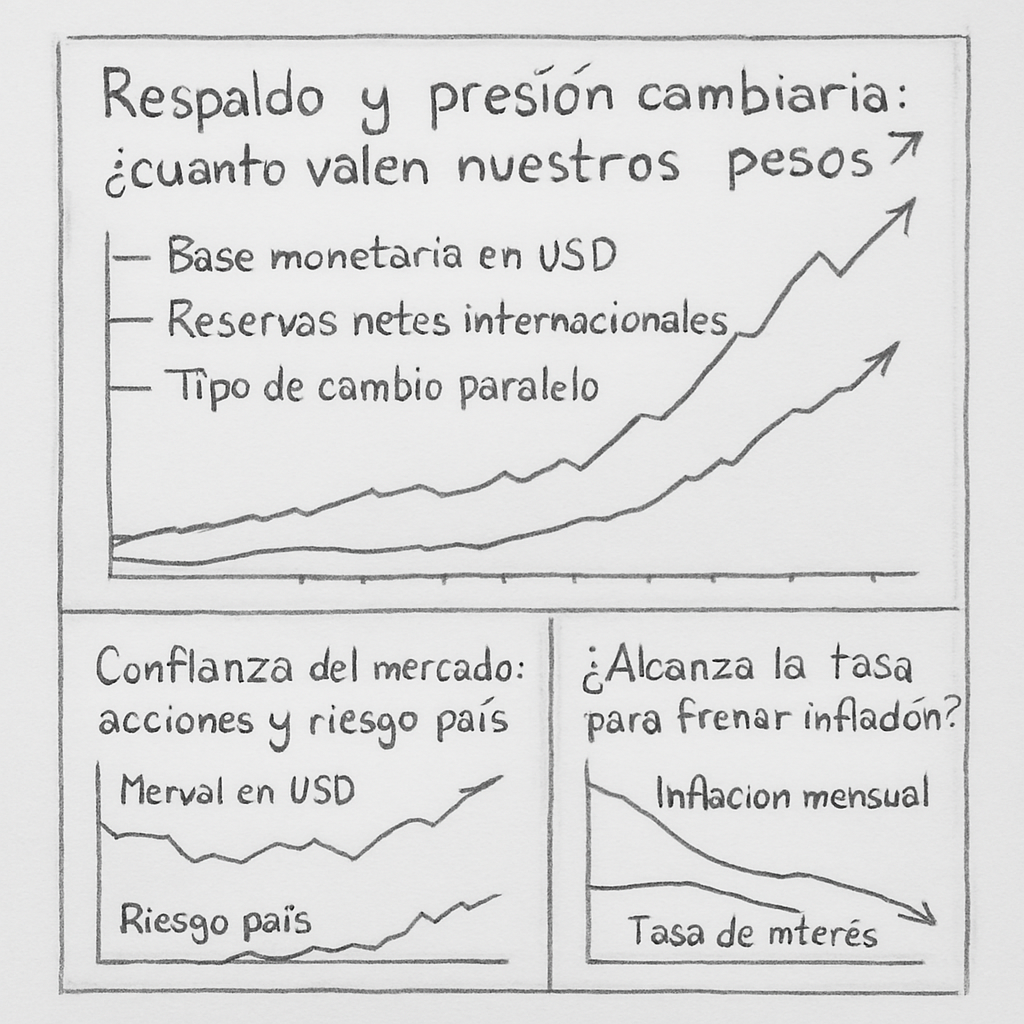